Using Machine Learning to Quantify the Importance of Pitching Statistics on Cy Young Voting: 

In baseball, the Cy Young award is given to the best pitcher in the both the National and American League of MLB. In baseball communities, there has been significant discourse about the changing importance of certain statistics to Cy Young voters. This project looks to use Machine Learning on data from 1967-2022 to quantify the relative importance of certain statistics on predicting Cy Young vote share. 

Step 1: Compile and Parse HTML Data

To get the Cy Young voting data, we need to scrape the tables from Baseball Reference. Thus, I created a web scraper that reads the html code, then used BeautifulSoup to parse the html for the table. Be sure to avoid running the code multiple times because Baseball Reference will time you out.

In [1]:
import requests
from bs4 import BeautifulSoup, Comment

In [64]:
years = list(range(2000,2023))

In [29]:
url_start = "https://www.baseball-reference.com/awards/awards_{}.shtml"

In [67]:
for a in years:
    url = url_start.format(a)
    
    data = requests.get(url)
    
    with open("cy/{}.html".format(a), "w+") as f:
        f.write(data.text)

In [68]:
years = list(range(1967,2000))

In [69]:
for a in years:
    url = url_start.format(a)
    
    data = requests.get(url)
    
    with open("cy/{}.html".format(a), "w+") as f:
        f.write(data.text)

I have all the HTML code for every year, now I am testing the parser on just 1967 to see if it works, then scaling it up. 

In [2]:
year = 1967

In [30]:
url = url_start.format(year)
data = requests.get(url)
with open("cy/{}.html".format(year), "w+") as f:
    f.write(data.text)

In [3]:
with open("cy/1967.html") as f:
    page = f.read()


In [4]:
soup = BeautifulSoup(page, 'html.parser')


comments = soup.find_all(text=lambda text: isinstance(text, Comment))
target_comment = None

for comment in comments:
    if 'id="AL_CYA_voting"' in comment:  # Replace 'your_unique_identifier' with a specific identifier within the comment.
        target_comment = comment
        break

if target_comment is None:
    print("Could not find the target comment.")
else:
    # Now you have the target comment containing the table data.
    print(target_comment)




<div class="table_container" id="div_AL_CYA_voting">
    
    <table class="sortable stats_table" id="AL_CYA_voting" data-cols-to-freeze=",2">
    <caption>AL Cy Young Voting Table</caption>
    

   <colgroup><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col></colgroup>
   <thead>      
      <tr>
         <th aria-label="Rank" data-stat="rank" scope="col" class=" poptip sort_default_asc show_partial_when_sorting center" >Rank</th>
         <th aria-label="Name" data-stat="player" scope="col" class=" poptip sort_default_asc show_partial_when_sorting left" data-tip="&lt;strong&gt;Player Name&lt;/strong&gt;&lt;br&gt;&lt;strong&gt;Bold&lt;/strong&gt; can mean player is active for this team&lt;br&gt;or player has appeared in the majors&lt;br&gt;* means LHP or LHB,&lt;br&gt;# means switch hitter,&lt;br&gt;+ can mean HOFer." >Name</th>
         <th aria-label="Tm" data-stat="team_ID" s

In [5]:
import pandas as pd

In [6]:
al_cy_1967 = pd.read_html(str(target_comment))[0]
al_cy_1967

,Rank,Name,Tm,Vote Pts,1st Place,Share,WAR,W,L,W-L%,...,HR,BB,IBB,SO,HBP,BK,WP,BF,WHIP,ERA+
0,1,Jim Lonborg,BOS,18.0,18.0,90%,4.0,22,9,0.710,...,23,83,5,246,19,1,12,1130,1.138,112
1,2,Joe Horlen,CHW,2.0,2.0,10%,5.5,19,7,0.731,...,13,58,4,103,4,0,5,995,0.953,146


Now that we got it to work for one year and one league, let's try to scale it up to every year. Since AL and NL are 2 different entities for voting purposes, we're gonna have to do 2 different loops for each league.

In [7]:
import html5lib

In [8]:
years_cy = list(range(1967,2023))

In [19]:
dfs_al = []

for year_cy in years_cy:
    with open("cy/{}.html".format(year_cy)) as f:
        page = f.read()
    soup = BeautifulSoup(page, 'html5lib')


    comments = soup.find_all(text=lambda text: isinstance(text, Comment))
    table_html = None

    for comment in comments:
        if 'id="AL_CYA_voting"' in comment: 
            table_html = comment
            al_cy = pd.read_html(str(table_html))[0]
            al_cy["Year"] = year_cy

    dfs_al.append(al_cy)
    
        

In [20]:
al_cys = pd.concat(dfs_al)

In [22]:
dfs_nl = []

for year_cy in years_cy:
    with open("cy/{}.html".format(year_cy)) as f:
        page = f.read()
    soup = BeautifulSoup(page, 'html5lib')


    comments = soup.find_all(text=lambda text: isinstance(text, Comment))
    table_html = None

    for comment in comments:
        if 'id="NL_CYA_voting"' in comment: 
            table_html = comment
            nl_cy = pd.read_html(str(table_html))[0]
            nl_cy["Year"] = year_cy

    dfs_nl.append(nl_cy)

In [23]:
nl_cys = pd.concat(dfs_nl)

In [24]:
al_cys['League'] = 'AL'
nl_cys['League'] = 'NL'

Now that we successfully parsed all the html and created both an NL and AL Cy Young voting dataset, I created a column just to identify the league in case we need it later. Now, we need to combine the datasets using pd.concat (below). 

In [25]:
cy = pd.concat([al_cys,nl_cys])

Step 2: Data Cleaning

In [26]:
cy['Share'] = cy['Share'].str.strip('%')

In [29]:
cy['Share'] = pd.to_numeric(cy['Share'])/100

In [40]:
cy = cy.dropna()
print(cy[cy.isna() == True].count())

Rank         0
Name         0
Tm           0
Vote Pts     0
1st Place    0
Share        0
WAR          0
W            0
L            0
W-L%         0
ERA          0
G            0
GS           0
GF           0
CG           0
SHO          0
SV           0
IP           0
H            0
R            0
ER           0
HR           0
BB           0
IBB          0
SO           0
HBP          0
BK           0
WP           0
BF           0
WHIP         0
ERA+         0
Year         0
League       0
dtype: int64


Step 3: Exploratory Data Analysis and Model Selection

For most other projects, Exploratory Data Analysis takes some time, but I have a strong understanding of baseball statistics and sabermetrics, so feature selection is generally easy. Just to be safe, I included a correlation heatmap just to examine potential correlations between variables. 

Now for model selection, I started off with testing a Linear Regression model (which wasn't helpful so I didn't include the code). Instead, I found that a GradientBoostingRegressor model was powerful enough, but also had strong mechanisms to measure Feature Importance (which is my ultimate goal). 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns

In [44]:
cy['Year'] = pd.to_datetime(cy['Year'], format='%Y')

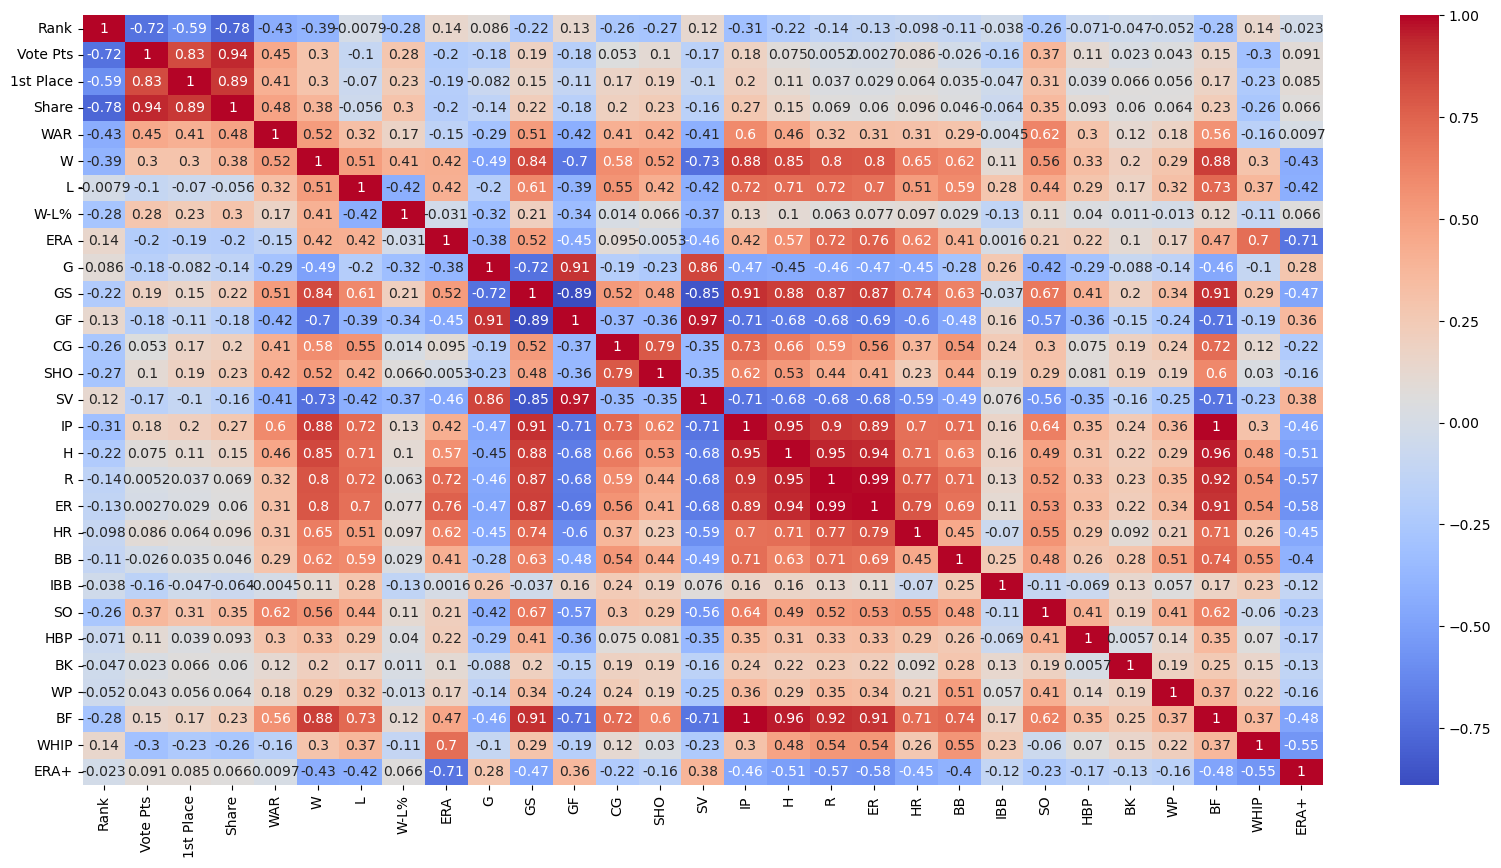

In [51]:
corr_matrix = cy.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True)
plt.show()

In [58]:
cy.columns

Index(['Rank', 'Name', 'Tm', 'Vote Pts', '1st Place', 'Share', 'WAR', 'W', 'L',
       'W-L%', 'ERA', 'G', 'GS', 'GF', 'CG', 'SHO', 'SV', 'IP', 'H', 'R', 'ER',
       'HR', 'BB', 'IBB', 'SO', 'HBP', 'BK', 'WP', 'BF', 'WHIP', 'ERA+',
       'Year', 'League'],
      dtype='object')

In [153]:
target = 'Share'
features = ['W','L','IP','ERA+','WHIP','BB','SV','WAR','SO']

I decided that the easiest way to measure the effects over time was to separate the data by decade, and train a model on each decade to measure the relative importance, so the code below creates a decade column. 

In [154]:
cy['Decade'] = (cy['Year'].dt.year // 10) * 10
decades = cy['Decade'].unique()

Now, the code below is the meat and potatoes of what we're trying to acheive. Below, we looped over each decade and trained a model on each decade to get the various feature importances over each statistic over the given decade, then created a dictionary with the decade as a key. However, the 1960s decade was creating some error so we decided to run it separately below. 

In [155]:
feature_importance_by_decade = {}

In [156]:
model = GradientBoostingRegressor()

decades = [1960, 1970, 1980, 1990, 2000, 2010, 2020]

def split_data_by_decade(data, decade):
    return data[data['Year'].dt.year < decade], data[data['Year'].dt.year >= decade]

feature_importances_by_decade = {}

for decade in decades:
    train_data, test_data = split_data_by_decade(cy, decade)

    X_train, X_test = train_data[features], test_data[features]
    y_train, y_test = train_data[target], test_data[target]

    if train_data.shape[0] > 0:
        model.fit(X_train, y_train)
        feature_importances_by_decade[decade] = model.feature_importances_

train_data_1960s = cy[cy['Year'].dt.year < 1970]
X_train_1960s, _ = train_data_1960s[features], train_data_1960s[features]
y_train_1960s, _ = train_data_1960s[target], train_data_1960s[target]
model.fit(X_train_1960s, y_train_1960s)
feature_importances_by_decade[1960] = model.feature_importances_


In [157]:
feature_importances_by_decade

{1970: array([0.43600059, 0.23681842, 0.01258332, 0.19826504, 0.00199847,
        0.02286688, 0.00524233, 0.04478428, 0.04144066]),
 1980: array([0.49799469, 0.09408598, 0.06967654, 0.02823896, 0.11404933,
        0.03073184, 0.02626114, 0.04777605, 0.09118547]),
 1990: array([0.45490926, 0.12259145, 0.05133517, 0.04310908, 0.11940468,
        0.05835708, 0.02898132, 0.05858135, 0.06273062]),
 2000: array([0.43072553, 0.08978996, 0.06481639, 0.06753889, 0.10098592,
        0.02412979, 0.0170636 , 0.15164689, 0.05330302]),
 2010: array([0.38267975, 0.0884771 , 0.0487251 , 0.13502705, 0.08494238,
        0.03427589, 0.01534702, 0.14104869, 0.06947702]),
 2020: array([0.34495469, 0.07279934, 0.03307938, 0.17323276, 0.10546998,
        0.0235316 , 0.01998066, 0.12336859, 0.10358303]),
 1960: array([0.42919105, 0.22973523, 0.00959939, 0.20577402, 0.01241184,
        0.00128439, 0.00867775, 0.0616133 , 0.04171304])}

Now, we have the dictionary with all the various feature importances over each decade, now we want to create a DataFrame so we can easily visualize it. 

In [158]:
feature_importances_df = pd.DataFrame.from_dict(feature_importances_by_decade, orient='index', columns=features)


In [159]:
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'index': 'Decade'}, inplace=True)


In [160]:
feature_importances_df.sort_values(by='Decade',ascending=True,inplace=True)

Now, we can easily graph our data, and the code for that is shown below. 

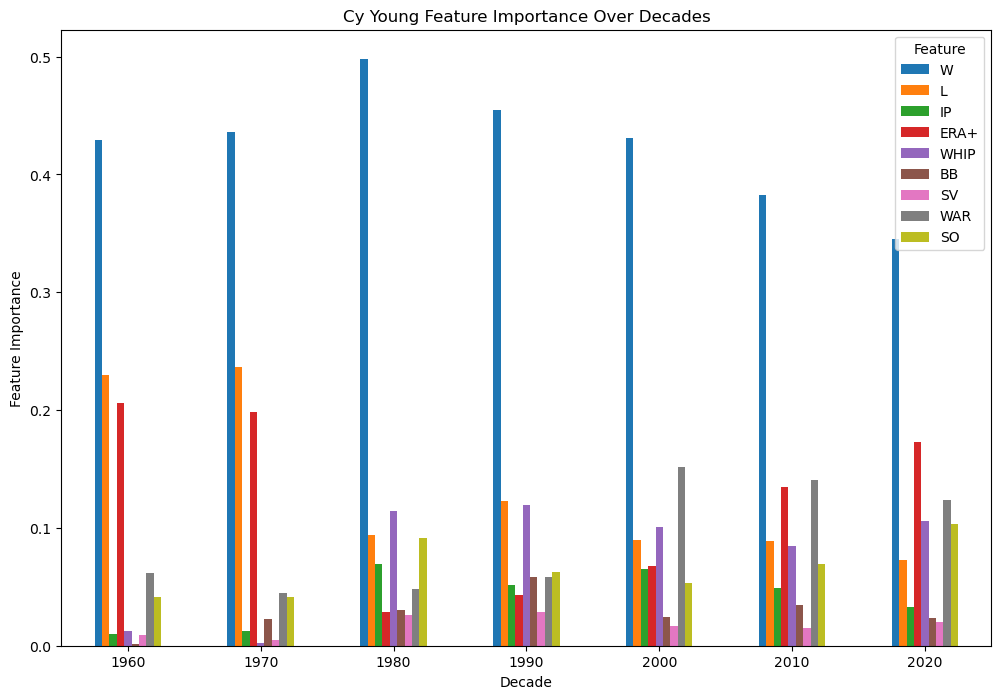

In [161]:
feature_importances_df.plot(x='Decade', kind='bar', figsize=(12, 8))
plt.title('Cy Young Feature Importance Over Decades')
plt.xlabel('Decade')
plt.ylabel('Feature Importance')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()

Check out my Tableau dashboard if you want a more interactive graph where you can focus on one variable!

https://public.tableau.com/app/profile/rohan.patel7712/viz/CyYoungStatisticImportance/Dashboard1?publish=yes